## model ref :

- nb : 
https://www.kaggle.com/shs037ucsd/predict-match-between-two-person-v1

- Classifier :
http://scikitlearn.org/stable/auto_examples/classification/plot_classifier_comparison.html

=========================================================

In [1]:
# Load basic library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import pylab as pl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# * 0 ) Data Preprocess 

In [2]:
df = pd.read_csv("/Users/yennanliu/Kaggle.com_mini_project/Speed_Dating/Speed_Dating_Data.csv", encoding="ISO-8859-1")
#input_vars = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']

In [3]:
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [4]:
shape(df)

(8378, 195)

In [5]:
### ONLY USING SPECIFIC FEATURES 

use_features = ['iid', 'gender', 'wave', 'pid', 'match', 'samerace', 'age_o', 'race_o', \
                 'pf_o_att', 'pf_o_sin', 'pf_o_int','pf_o_fun', 'pf_o_amb', 'pf_o_sha',\
                 'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal', 'date', 'go_out', 'sports',\
                 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',\
                 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy',\
                 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr2_1', 'sinc2_1',\
                 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1','fun3_1', 'intel3_1', 'amb3_1']

df_ = df[use_features]


In [6]:
df_.head(3)

,iid,gender,wave,pid,match,samerace,age_o,race_o,pf_o_att,pf_o_sin,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
0,1,0,1,11.0,0,0,27.0,2.0,35.0,20.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,1,0,1,12.0,0,0,22.0,2.0,60.0,0.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,1,0,1,13.0,1,1,22.0,4.0,19.0,18.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0


In [21]:
df_.groupby('match').count()['pid']

match
0    6701
1    1323
Name: pid, dtype: int64

### data in- equilibrium 
> no match cases (match = 0 ) are MUCH MORE than match cases (match = 1),
> need to do either re-sample nor sub-sample tricks following steps dealing with this issue

In [7]:
# only keep rows which have non-null data 
# https://stackoverflow.com/questions/36370839/better-way-to-drop-nan-rows-in-pandas

df_ = df_.dropna(how='any')

## 0-1) help function 

In [58]:

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

def train_test_separate(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    return X_train, X_test, y_train, y_test


def basic_fitting(X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    # ====  fitting ====
    model_clf = model
    model_clf.fit(X_train, y_train)
    #print (model_clf)
    print ('test data score : ', model_clf.score(X_test,y_test))
    print ('\n')
    print ('confusion matrix : ')
    print (confusion_matrix(y_test, model_clf.predict(X_test),labels=[0,1]))
    # ====  ROC curve  ====
    fpr, tpr, _ = roc_curve(y_test, model_clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    print ('ROC AUC: %0.2f' % roc_auc)
    # plot curve 
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def model_comparison(models,*args,**kwargs):
    #models = [clf_svc,clf_tree,clf_rf]
    
    for model in models: 
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        roc_auc = auc(fpr, tpr)
        print ('ROC AUC: %0.2f' % roc_auc)
        # plot curve 
        #plt.figure()
        plt.plot(fpr, tpr, label='{} ROC curve (area = %0.2f)' % roc_auc)
        #plt.plot(fpr, tpr, label='ROC curve (area = {}0.2f)'.format(roc_auc))
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


# * 1) ML 

### 1-0)  input, output values define

In [9]:
# X : inpurt feature
# y : output value

X = df_.drop('match', axis=1)
y = df_[['match']]

In [10]:
X_train, X_test, y_train, y_test = train_test_separate(X,y)

### 1-1) Support Vector Classifier

test data score :  0.731464174455


confusion matrix : 
[[1102  232]
 [ 199   72]]
ROC AUC: 0.55


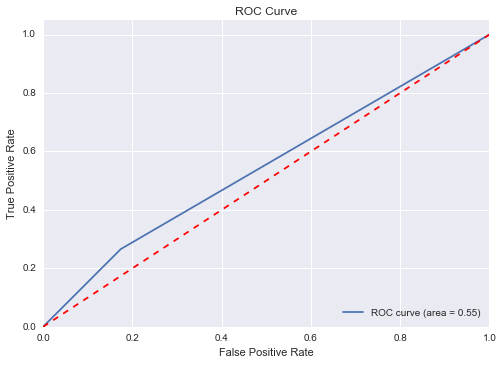

In [24]:
from sklearn.tree import DecisionTreeClassifier
clf_svc = DecisionTreeClassifier(random_state=0)
#clf_svc.fit(X_train, y_train)
#clf_svc.score(X_test,y_test)

basic_fitting(X,y,clf_svc)

### 1-2) Decision Tree Classifier

test data score :  0.731464174455


confusion matrix : 
[[1102  232]
 [ 199   72]]
ROC AUC: 0.55


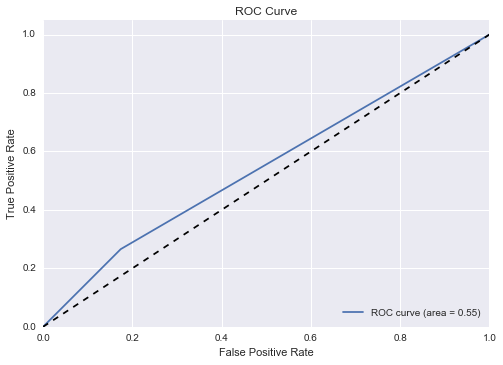

In [13]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=0)

basic_fitting(X,y,clf_tree)

### 1-3) Random Forest Classifier

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


test data score :  0.819937694704


confusion matrix : 
[[1289   45]
 [ 244   27]]
ROC AUC: 0.62


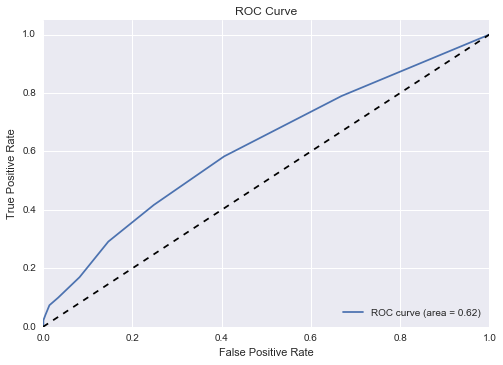

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=0)

basic_fitting(X,y,clf_rf)


### 1-4) K Neighbors Classifier

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


test data score :  0.807476635514


confusion matrix : 
[[1265   69]
 [ 240   31]]
ROC AUC: 0.58


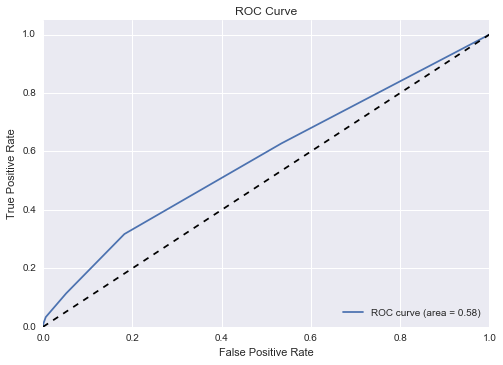

In [15]:
from sklearn.neighbors import KNeighborsClassifier

clf_kn = KNeighborsClassifier()

basic_fitting(X,y,clf_kn)

### 1-5) neural network Classifier

//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:904: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test data score :  0.833644859813


confusion matrix : 
[[1329    5]
 [ 262    9]]
ROC AUC: 0.59


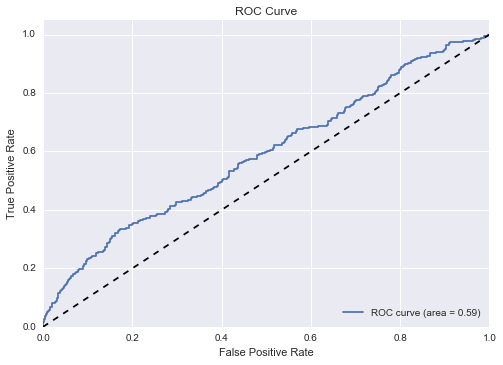

In [16]:
from sklearn.neural_network import MLPClassifier

clf_nn = MLPClassifier()

basic_fitting(X,y,clf_nn)


### 1-x) Model Comparison

ROC AUC: 0.55
ROC AUC: 0.55
ROC AUC: 0.62
ROC AUC: 0.58
ROC AUC: 0.59


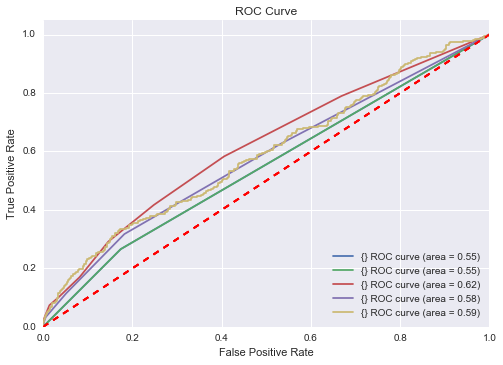

In [57]:
models = [clf_svc,clf_tree,clf_rf,clf_kn,clf_nn]
model_comparison(models)

### 1-x) XGBClassifier

In [17]:
#import xgboost as xgb

